In [1]:
from google.colab import drive
drive.mount("/content/mydrive")

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [2]:
import pandas as pd
data=pd.read_csv("/content/mydrive/Shared drives/2020 KU datathon/data/data.csv",sep=",")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = data.drop(['Unnamed: 0'],axis=1)

In [4]:
data.columns=['time_stamp_s','fire','dust','temperature','humidity','co2','moving','door','roomid']
data.head()

,time_stamp_s,fire,dust,temperature,humidity,co2,moving,door,roomid
0,2020-01-02 15:29:31,0,34,19.048489,26.161224,600,0,1,202
1,2020-01-02 15:30:31,0,34,19.048489,26.161224,600,0,1,202
2,2020-01-02 15:31:31,0,34,19.048489,26.161224,600,0,1,202
3,2020-01-02 15:32:31,0,34,19.048489,26.161224,600,0,1,202
4,2020-01-02 15:33:31,0,34,19.048489,26.161224,600,0,1,202


In [5]:
import numpy as np

data['roomid']=data['roomid'].astype(str)
conditions = [
    (data.roomid.str.startswith('2')),
    (data.roomid.str.startswith('3')),
    (data.roomid.str.startswith('4')),
    (data.roomid.str.startswith('5'))]
choices = ['floor2', 'floor3', 'floor4','floor5']
data['floor'] = np.select(conditions, choices, default='floorB') # floor 변수 생성!

In [6]:
# Outlier 제거 
# co2: 0<= data.co2<=3000 
# dust:  data.dust>=0 & data.dust <800
# humidity: data.humidity >= 0
# temperature: data.temperature >= 0

data = data[(data.co2 <= 3000) & (data.co2 >= 0) & (data.dust>=0) & (data.dust <800) & (data.humidity >= 0) & (data.temperature >= 0)]

In [ ]:
# 불쾌지수
data["stress"] = 9/5*data.temperature-0.55*(1-data.humidity/100)*(9/5*data.temperature-26)+32

In [ ]:
# score 
import numpy as np
co2conditions = [
              (data.co2 < 350),
              (data.co2>=350) & (data.co2<450),
              (data.co2>=450) & (data.co2<750),
              (data.co2>=750) & (data.co2<1000),
              (data.co2 >= 1000)]
co2choices= [5,4,3,2,1]
data["co2score"] = np.select(co2conditions, co2choices)

dustconditions = [
              (data.dust <= 15),
              (data.dust>=16) & (data.dust<=50),
              (data.dust>=51) & (data.dust<=75),
              (data.dust>=76) & (data.co2<=100),
              (data.co2 >= 101)]
dustchoices= [5,4,3,2,1]
data["dustscore"] = np.select(dustconditions, dustchoices)

stressconditions = [
              (data.stress < 68),
              (data.stress>=68) & (data.dust<75),
              (data.dust>=75) & (data.dust<80),
              (data.dust >= 80)]
stresschoices= [10,7.5,5,2.5]
data["stressscore"] = np.select(stressconditions, stresschoices)

data["totalscore"] = data["co2score"] + data["dustscore"] + data["stressscore"]

SSSconditions = [
                 (data.totalscore > 16) & (data.totalscore <= 20),
                (data.totalscore > 12) & (data.totalscore <= 16),
                 (data.totalscore > 8) & (data.totalscore <= 12),
                 (data.totalscore > 4) & (data.totalscore <= 8),
                 (data.totalscore < 4)
]
SSSchoices= [5,4,3,2,1]
data["SSS"]= np.select(SSSconditions, SSSchoices)



In [ ]:
data

,time_stamp_s,fire,dust,temperature,humidity,co2,moving,door,roomid,floor,stress,co2score,dustscore,stressscore,totalscore,SSS
0,2020-01-02 15:29:31,0,34,19.048489,26.161224,600,0,1,202,floor2,62.921706,3,4,10.0,17.0,5
1,2020-01-02 15:30:31,0,34,19.048489,26.161224,600,0,1,202,floor2,62.921706,3,4,10.0,17.0,5
2,2020-01-02 15:31:31,0,34,19.048489,26.161224,600,0,1,202,floor2,62.921706,3,4,10.0,17.0,5
3,2020-01-02 15:32:31,0,34,19.048489,26.161224,600,0,1,202,floor2,62.921706,3,4,10.0,17.0,5
4,2020-01-02 15:33:31,0,34,19.048489,26.161224,600,0,1,202,floor2,62.921706,3,4,10.0,17.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17880064,2020-03-05 08:55:43,0,36,24.228711,27.427704,741,0,0,B141,floorB,68.582020,3,4,7.5,14.5,4
17880065,2020-03-05 08:56:44,0,41,24.207261,27.442963,729,0,0,B141,floorB,68.560295,3,4,7.5,14.5,4
17880066,2020-03-05 08:57:44,0,39,24.228711,27.526886,733,0,0,B141,floorB,68.591627,3,4,7.5,14.5,4
17880067,2020-03-05 08:58:44,0,38,24.239436,27.503998,742,0,0,B141,floorB,68.601017,3,4,7.5,14.5,4


In [ ]:
data.describe()
# (나리)
# 0번 열은 ms기준의 시간 데이터고 2번 열은 s 기준의 시간 데이터. 따라서 분 단위로 측정된 이 데이터에서는 두개를 크게 구분 지을 필요는 없어보임
# 두 변수는 describe에서는 제외됨
# 1번 열은 buildingid로 여기서는 미래관이기 때문에 이것 또한 빼도 될듯
# 여기서 주목할만한 점은, 8번 열과 9번 열은 각각 움직임 감지, 그리고 문 열림 유무를 0,1로 표기한 것인데, 
# 75분위수도 0인것으로 보아 0의 비율이 매우 높은 것을 확인 --> 정확한 비율 확인 필요
# 10번열은 방 id로 describe에서 제외.
# 여기서 co2열이 제외되는데 그 이유를 모르겠음..-> float가 아니라 int type이어서 그럼 astype을 사용해서 변환해보려고 했으나 실패..ㅠㅠ
# 그리고 humidity가 -로 나오는게 가능.,? 좀 이상한듯  temperature와 dust도 마찬가지--> 이부분에 대한 논의 필요

,fire,dust,temperature,humidity,co2,moving,door
count,1.788007e+07,1.788007e+07,1.788007e+07,1.788007e+07,1.788007e+07,1.788007e+07,1.788007e+07
mean,3.060794e-02,4.807895e+01,2.122281e+01,2.490630e+01,7.508689e+02,7.729444e-03,2.090574e-02
std,1.722530e-01,2.020585e+01,4.411856e+00,6.585345e+00,4.619118e+02,8.757683e-02,1.430688e-01
min,0.000000e+00,-9.900000e+01,-9.900000e+01,-9.900000e+01,-9.900000e+01,0.000000e+00,0.000000e+00
25%,0.000000e+00,3.300000e+01,1.901631e+01,2.100375e+01,6.070000e+02,0.000000e+00,0.000000e+00
50%,0.000000e+00,4.400000e+01,2.092538e+01,2.494815e+01,6.870000e+02,0.000000e+00,0.000000e+00
75%,0.000000e+00,5.800000e+01,2.334925e+01,2.893832e+01,8.350000e+02,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+03,3.987663e+01,5.625156e+01,6.000000e+04,1.000000e+00,1.000000e+00


In [ ]:
# time_stamp_s to datetime format (돌렸는데 너무 데이터 커져서 새로운 데이터셋으로 만드는 건 포기)
# import numpy as np
# data['time_stamp_s']=pd.to_datetime(data['time_stamp_s'],infer_datetime_format=True)
# data['Year']=data['time_stamp_s'].dt.year
# data['Month']=data['time_stamp_s'].dt.month
# data['Day']=data['time_stamp_s'].dt.day
#data['Week']=data['time_stamp_s'].dt.week
# data['Hour']=data['time_stamp_s'].dt.hour 
#data['Minute']=data['time_stamp_s'].dt.minute
#data['Second']=data['time_stamp_s'].dt.second


# data['Season']=np.where(data['Month'].isin([3,4,5]),'Spring',
#                      np.where(data['Month'].isin([6,7,8]),'Summer',
#                               np.where(data['Month'].isin([9,10,11]),'Fall','Winter')))
# data.head()

In [ ]:
data.dtypes

time_stamp_s     object
fire              int64
dust              int64
temperature     float64
humidity        float64
co2              object
moving            int64
door              int64
roomid           object
dtype: object

In [8]:
# time_stamp_s into datetime format 
data['time_stamp_s']=pd.to_datetime(data['time_stamp_s'],infer_datetime_format=True)
data.dtypes

time_stamp_s    datetime64[ns]
fire                     int64
dust                     int64
temperature            float64
humidity               float64
co2                      int64
moving                   int64
door                     int64
roomid                  object
floor                   object
dtype: object

In [ ]:
iotmov=data.groupby("moving")
iotmov.count()
# 전체 17883218개의 데이터 중 움직임이 감지된 데이터는 138212개에 불과. 약 1%에 못미치는 수준

,time_stamp_ms,buildingid,time_stamp_s,fire,dust,temperature,humidity,co2,door,roomid
moving,,,,,,,,,,
0,17745006,17745006,17745006,17745006,17745006,17745006,17745006,17745006,17745006,17745006
1,138212,138212,138212,138212,138212,138212,138212,138212,138212,138212


In [ ]:
iotdoor=data.groupby("door")
iotdoor.count()
# door의 경우 전체 17883218개의 데이터 중 문이 열린 데이터는 373894개. 이는 약 전체의 2%

,time_stamp_ms,buildingid,time_stamp_s,fire,dust,temperature,humidity,co2,moving,roomid
door,,,,,,,,,,
0,17509324,17509324,17509324,17509324,17509324,17509324,17509324,17509324,17509324,17509324
1,373894,373894,373894,373894,373894,373894,373894,373894,373894,373894


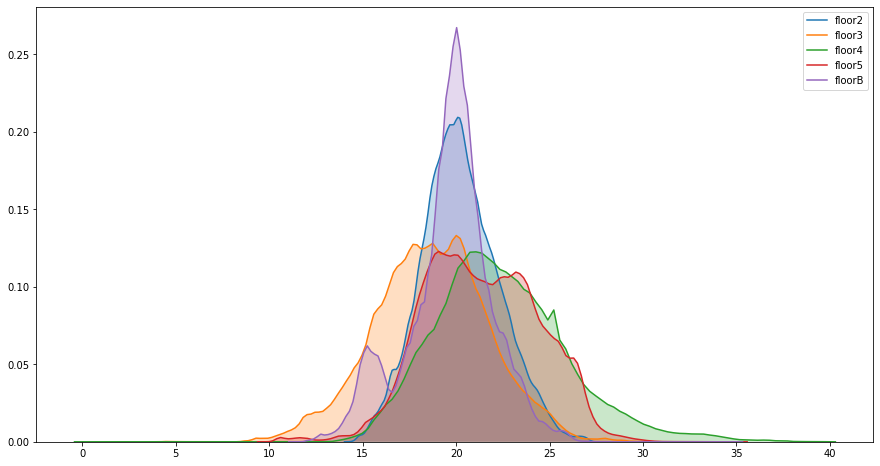

In [ ]:
# floor에 따른 temperature의 분포 EDA#
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,8))
a=data['floor'].unique()
for i, name in enumerate(a):
    sns.kdeplot(data[data['floor'] == name]['temperature'], label=name,legend=True,shade=True)

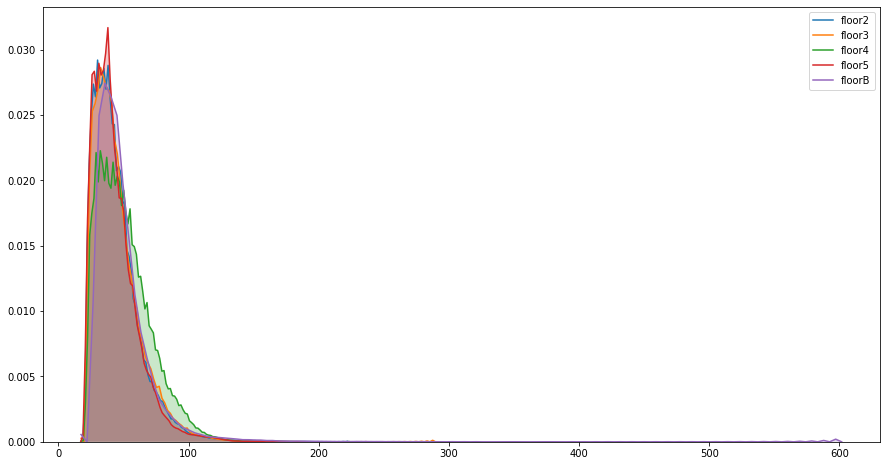

In [ ]:
# floor에 따른 dust의 분포 EDA#
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,8))
a=data['floor'].unique()
for i, name in enumerate(a):
    sns.kdeplot(data[data['floor'] == name]['dust'], label=name,legend=True,shade=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


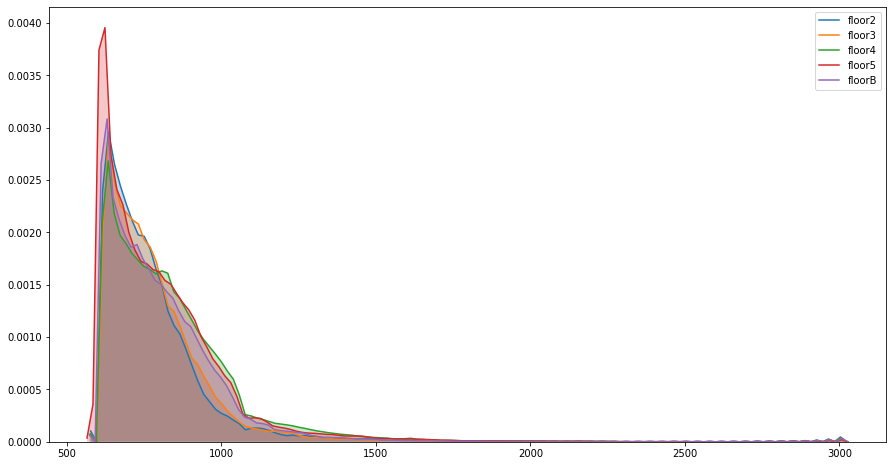

In [8]:
# floor에 따른 co2의 분포 EDA#
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,8))
a=data['floor'].unique()
for i, name in enumerate(a):
    sns.kdeplot(data[data['floor'] == name]['co2'], label=name,legend=True,shade=True)

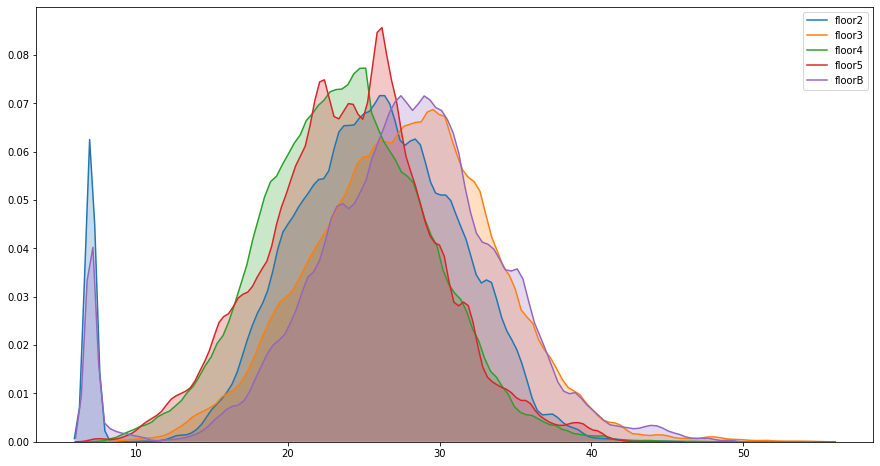

In [ ]:
# floor에 따른 humidity의 분포 EDA#
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,8))
a=data['floor'].unique()
for i, name in enumerate(a):
    sns.kdeplot(data[data['floor'] == name]['humidity'], label=name,legend=True,shade=True)

In [ ]:
iotmovdoor=data.groupby(['door','moving'])
iotmovdoor.count()
# 두 변수로 그룹화를 한 결과 사실 두 변수 모두에서 1,1이 나타나는 경우가 대다수일 줄 알았는데 아님..
# moving 변수에 대해서 어떻게 움직임을, 어디서 움직임을 감지하는지에 대한 질문이 필요해보임.

In [ ]:
iotdoor.mean()
# 문이 열려있는지 아닌지로 구분하고 각각의 평균 비교, 열려있는 경우의 미세먼지가 좀더 높고, 온도는 꽤나 높은 것을 확인할 수 있음. 오히려 humidity는 낮음.
# 각각의 변수가 유의미한지 파악필요

In [ ]:
iotdoor.std()
# 변동성의 경우 dust의 경우에는 door=1인 경우, temperature은 door=0인경우, humidity는 door=0인경우가 더 높은 것을 확인

,buildingid,fire,dust,temperature,humidity,moving
door,,,,,,
0,0.0,0.172118,20.081488,4.418865,6.595953,0.085404
1,0.0,0.177764,25.279419,3.648838,5.945979,0.157813


In [ ]:
iotmov.mean()
# moving으로 데이터를 구별한 경우 moving이 없는 경우가 오히려 dust가 높음..(엥 왜지), temperature은 moving이 있는 경우 약간 더 높은 것을 확인. humidity는 큰 차이 없음
# 이렇게 봤을 때 temperature가 door이 0,1로 구별했을 때 꽤 차이나는 것으로 볼 수 있을듯

In [ ]:
iotmov.std()
# 변동성은 dust의 경우 moving이 있을 때 변동성이 더 높고, temperature은 없을 때.. 그리고 humidity도 없을 때 변동성이 더 높음
# 여기서 주목할 만한 점은 dust의 변동성이 매우 높다는 것 -> 밑 그래프에서도 두드러짐.
# 이거를 근거로 우리의 아이디어가 필요한 이유에 대해서도 이야기해볼 수 있을듯?

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


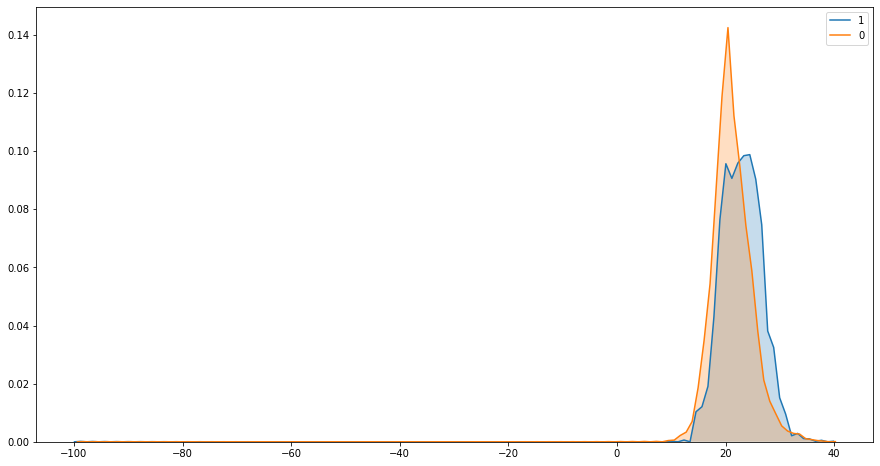

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# door에 따른 temperature의 분포 EDA
plt.figure(figsize=(15,8))
a=data['door'].unique()
for i, name in enumerate(a):
    sns.kdeplot(data[data['door'] == name]['temperature'], label=name,legend=True,shade=True)
    ##1일 때 더 오른쪽으로 치우친 분포임을 확인

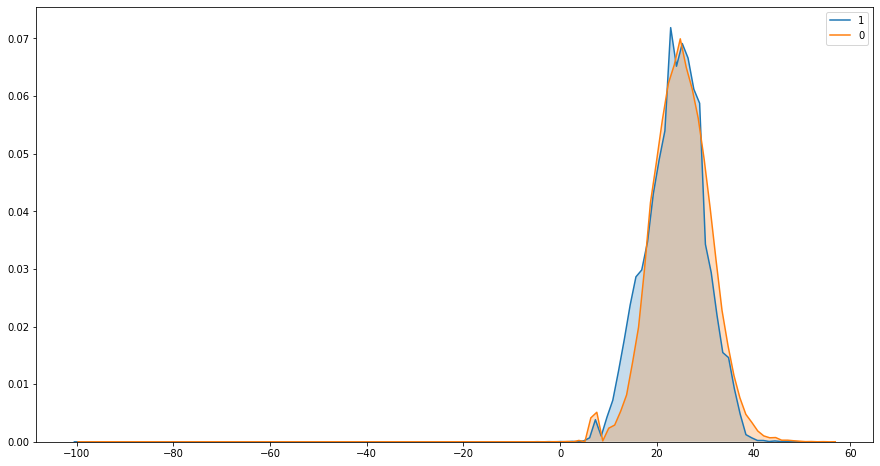

In [ ]:
# door에 따른 humidity의 분포 EDA
plt.figure(figsize=(15,8))
a=data['door'].unique()
for i, name in enumerate(a):
    sns.kdeplot(data[data['door'] == name]['humidity'], label=name,legend=True,shade=True)
    #이건 분포에 큰 차이는 없어보임..

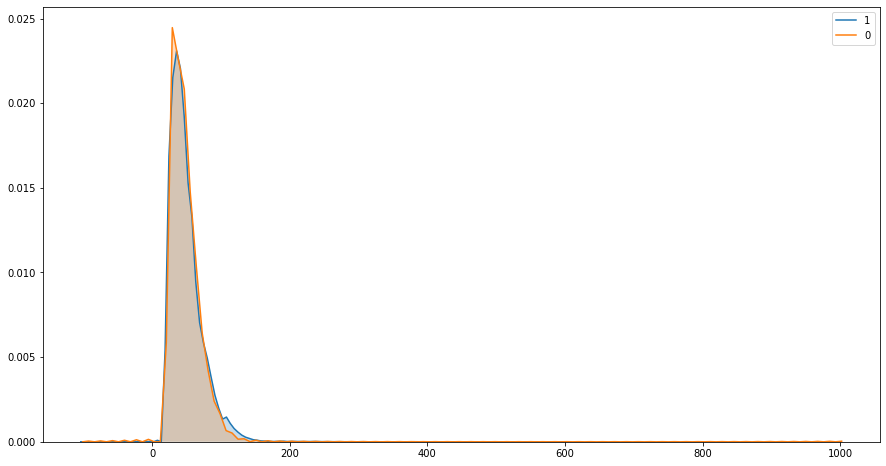

In [ ]:
# door에 따른 dust의 분포 EDA
plt.figure(figsize=(15,8))
a=datat['door'].unique()
for i, name in enumerate(a):
    sns.kdeplot(data[data['door'] == name]['dust'], label=name,legend=True,shade=True)
    #얘도 큰 차이 x

In [ ]:
# moving에 따른 temperature의 분포 EDA
plt.figure(figsize=(15,8))
a=data['moving'].unique()
for i, name in enumerate(a):
    sns.kdeplot(data[data['moving'] == name]['temperature'], label=name,legend=True,shade=True)
    ##1일 때가 좀더 오른쪽으로 치우친 것 확인

In [ ]:
# moving에 따른 humidity의 분포 EDA
plt.figure(figsize=(15,8))
a=data['moving'].unique()
for i, name in enumerate(a):
    sns.kdeplot(data[data['moving'] == name]['humidity'], label=name,legend=True,shade=True)

In [ ]:
data_Jan = data[data['time_stamp_s'].dt.month==1]

In [ ]:
df1=data_Jan.groupby(data_Jan['time_stamp_s'].dt.day)['dust','temperature','humidity','co2'].mean() # 연속형 변수만.
df1.head(6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,dust,temperature,humidity
time_stamp_s,,,
2,53.183151,19.147655,23.719808
3,58.104472,18.504515,25.076176
4,54.691177,19.231039,23.285727
5,59.282752,17.380079,24.323679
6,49.606270,18.896336,25.062110
7,29.390609,19.096631,33.241671
8,40.487363,20.199255,34.265953
9,65.583646,20.107485,28.256333
10,74.185578,20.590094,25.544553


In [9]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
data['dust'] = std.fit_transform(data['dust'].values.reshape(-1,1))
data['temperature'] =  std.fit_transform(data['temperature'].values.reshape(-1,1))
data['humidity'] =  std.fit_transform(data['humidity'].values.reshape(-1,1))
data['co2'] =  std.fit_transform(data['co2'].values.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


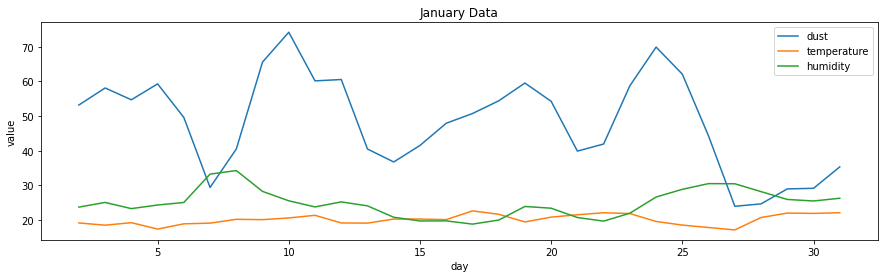

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,4)
df1=data_Jan.groupby(data_Jan['time_stamp_s'].dt.day)['dust','temperature','humidity'].mean()
df1.plot()
plt.title("January Data")
plt.xlabel("day")
plt.ylabel("value")
plt.show() # 1월 날짜별 plot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


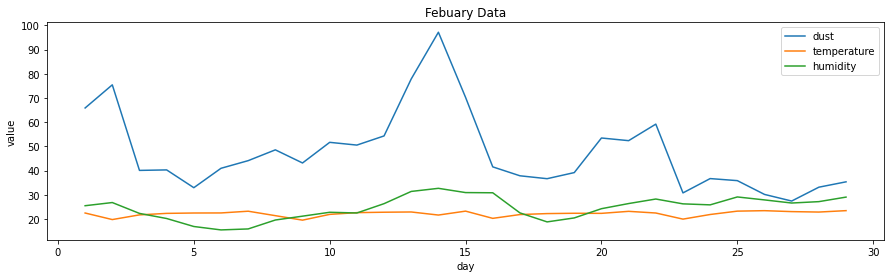

In [ ]:
data_Feb = data[data['time_stamp_s'].dt.month==2]
df2=data_Feb.groupby(data_Feb['time_stamp_s'].dt.day)['dust','temperature','humidity','co2'].mean()
df2.plot()
plt.title("Febuary Data")
plt.xlabel("day")
plt.ylabel("value")
plt.show() # 2월 날짜별 plot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


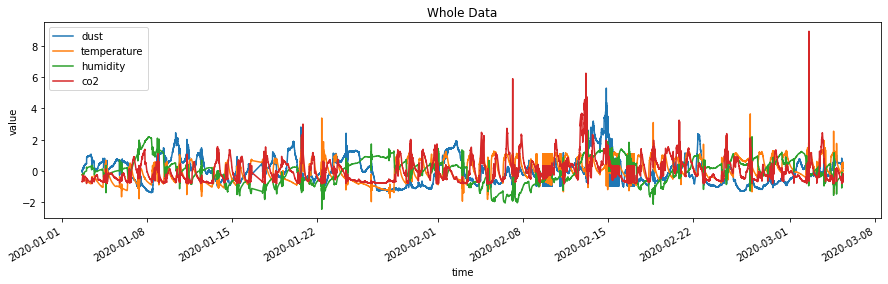

In [10]:
import matplotlib.pyplot as plt
df3 = data.groupby(data['time_stamp_s'])['dust','temperature','humidity','co2'].mean()
plt.rcParams["figure.figsize"] = (15,4)
df3.plot()
plt.title("Whole Data")
plt.xlabel("time")
plt.ylabel("value")
plt.show() # 전체 기간 동안의 plot (단위: 시간(초))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


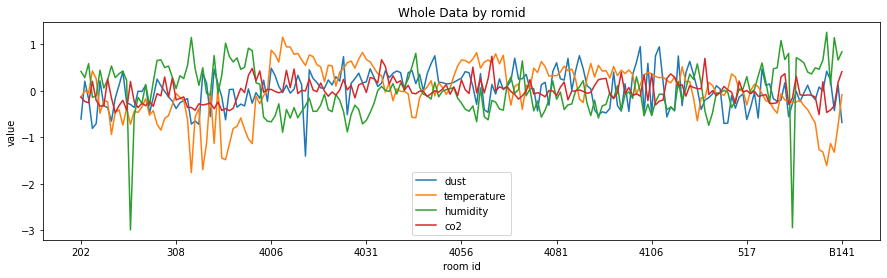

In [11]:
import matplotlib.pyplot as plt
dfabc = data.groupby(data['roomid'])['dust','temperature','humidity','co2'].mean()
plt.rcParams["figure.figsize"] = (15,4)
dfabc.plot()
plt.title("Whole Data by romid")
plt.xlabel("room id")
plt.ylabel("value")
plt.show() # 전체 기간 동안의 plot (단위: 시간(초))

In [12]:
dfabc.min()

dust          -1.402246
temperature   -1.757289
humidity      -2.989192
co2           -0.509748
dtype: float64

In [13]:
dfabc[dfabc['humidity']== -2.989192]

,dust,temperature,humidity,co2
roomid,,,,


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


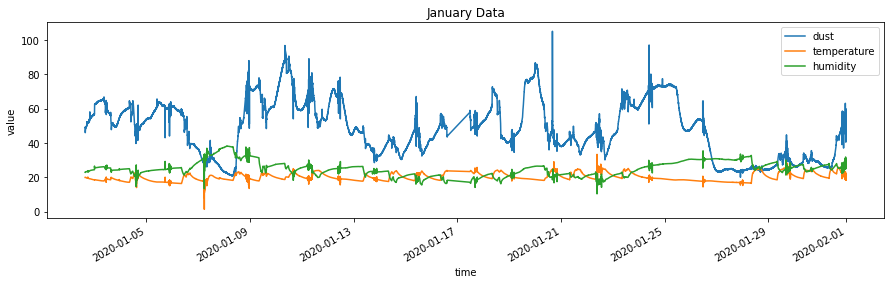

In [ ]:
import matplotlib.pyplot as plt
df4=data_Jan.groupby(data_Jan['time_stamp_s'])['dust','temperature','humidity','co2'].mean()
df4.plot()
plt.title("January Data")
plt.xlabel("time")
plt.ylabel("value")
plt.show() # 1월 시간별 plot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


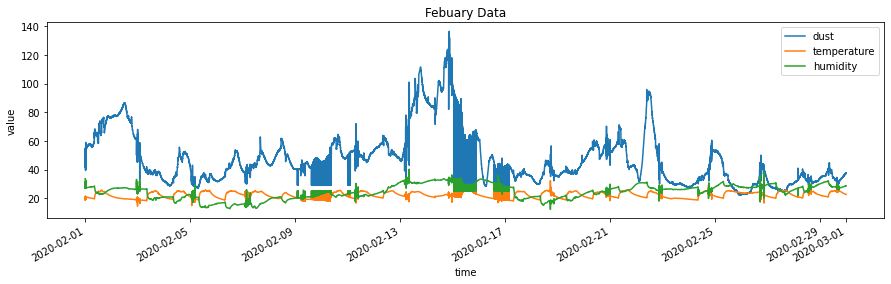

In [ ]:
import matplotlib.pyplot as plt
df5=data_Feb.groupby(data_Feb['time_stamp_s'])['dust','temperature','humidity','co2'].mean()
df5.plot()
plt.title("Febuary Data")
plt.xlabel("time")
plt.ylabel("value")
plt.show() # 2월 시간별 plot

In [29]:
import numpy as np
data['Hour']=data['time_stamp_s'].dt.hour # hour 라는 시간 변수 추가

In [ ]:
data.head(6)

,time_stamp_s,fire,dust,temperature,humidity,co2,moving,door,roomid,Hour
0,2020-01-02 15:29:31,0,34,19.048489,26.161224,600,0,1,202,15
1,2020-01-02 15:30:31,0,34,19.048489,26.161224,600,0,1,202,15
2,2020-01-02 15:31:31,0,34,19.048489,26.161224,600,0,1,202,15
3,2020-01-02 15:32:31,0,34,19.048489,26.161224,600,0,1,202,15
4,2020-01-02 15:33:31,0,34,19.048489,26.161224,600,0,1,202,15
5,2020-01-02 15:34:31,0,34,19.048489,26.161224,600,0,1,202,15


In [23]:
datawot= data.drop(['time_stamp_s'],axis=1)
datawot.corr()

,fire,dust,temperature,humidity,co2,moving,door,Hour
fire,1.000000,-0.034789,0.011107,-0.015186,0.002123,-0.007984,0.001755,0.003812
dust,-0.034789,1.000000,-0.042207,0.110509,0.036761,-0.002398,0.010032,0.002031
temperature,0.011107,-0.042207,1.000000,-0.477066,0.263958,0.016520,0.070354,0.203566
humidity,-0.015186,0.110509,-0.477066,1.000000,-0.045950,0.000407,-0.028143,-0.089337
co2,0.002123,0.036761,0.263958,-0.045950,1.000000,0.007125,0.034238,0.167928
moving,-0.007984,-0.002398,0.016520,0.000407,0.007125,1.000000,0.029826,0.001869
door,0.001755,0.010032,0.070354,-0.028143,0.034238,0.029826,1.000000,0.018480
Hour,0.003812,0.002031,0.203566,-0.089337,0.167928,0.001869,0.018480,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

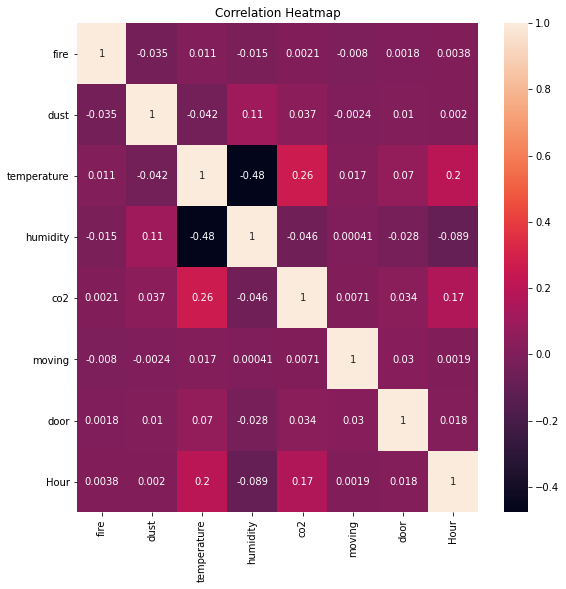

In [24]:
# %matplotlib inline # In Jupyter notebook
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(data = datawot.corr(), annot=True ) # 상관관계 거의 없음
plt.title("Correlation Heatmap")

In [25]:
dfhour=data.groupby('Hour')['dust','temperature','humidity','co2'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


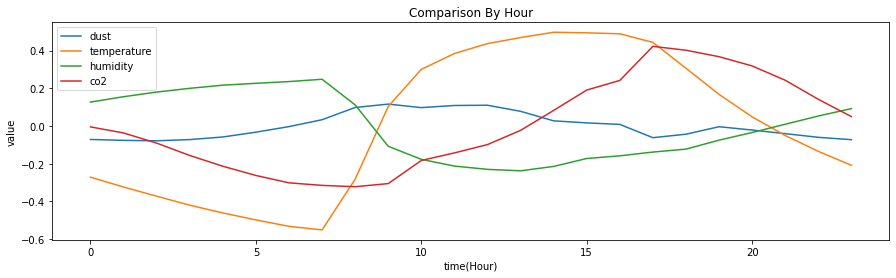

In [26]:
# Time(Hour)가 유의미한 변수인지 시각화로 확인
plt.rcParams["figure.figsize"] = (15,4)
dfhour.plot()
plt.title("Comparison By Hour")
plt.xlabel("time(Hour)")
plt.ylabel("value")
plt.show() # 전체 기간 동안의 plot (단위: 시간(초))

In [34]:
# At least one mean dust regarding each hour is different
import statsmodels.api as sm
from statsmodels.formula.api import ols
lmdust = ols('dust~Hour', data)
table = sm.stats.anova_lm(lmdust.fit())
print(table)

                  df        sum_sq    mean_sq          F        PR(>F)
Hour             1.0  9.856756e+01  98.567557  98.568103  3.140816e-23
Residual  17416974.0  1.741688e+07   0.999994        NaN           NaN


In [35]:
# At least one mean temperature regarding each hour is different
lmtemp = ols('temperature~Hour', data)
table = sm.stats.anova_lm(lmtemp.fit())
print(table)

                  df        sum_sq        mean_sq              F  PR(>F)
Hour             1.0  7.129155e+05  712915.508724  743342.068602     0.0
Residual  17416974.0  1.670406e+07       0.959068            NaN     NaN


In [37]:
lmco2 = ols('co2~Hour', data)
table = sm.stats.anova_lm(lmco2.fit())
print(table)

                  df        sum_sq        mean_sq              F  PR(>F)
Hour             1.0  7.255458e+05  725545.813702  757083.870706     0.0
Residual  17416974.0  1.669143e+07       0.958343            NaN     NaN


In [36]:
# At least one mean humidity regarding each hour is different
lmhumid = ols('humidity~Hour', data)
table = sm.stats.anova_lm(lmhumid.fit())
print(table)
# conclude that time(Hour) variable is statistically significant

                  df        sum_sq        mean_sq              F  PR(>F)
Hour             1.0  1.393501e+05  139350.114075  140474.005501     0.0
Residual  17416974.0  1.727763e+07       0.991999            NaN     NaN


In [30]:
datah12 = data[data['Hour']==12]

In [16]:
datawot12= datah8.drop(['time_stamp_s','Hour'],axis=1)
datawot12.corr()

,fire,dust,temperature,humidity,co2,moving,door
fire,1.000000,-0.038078,-0.026317,-0.013291,-0.009294,-0.011210,0.002914
dust,-0.038078,1.000000,-0.085751,0.086596,0.039397,0.008006,0.023112
temperature,-0.026317,-0.085751,1.000000,-0.448188,0.132042,0.006233,0.045963
humidity,-0.013291,0.086596,-0.448188,1.000000,0.000293,0.002676,-0.000383
co2,-0.009294,0.039397,0.132042,0.000293,1.000000,0.010427,0.009984
moving,-0.011210,0.008006,0.006233,0.002676,0.010427,1.000000,0.045558
door,0.002914,0.023112,0.045963,-0.000383,0.009984,0.045558,1.000000


Text(0.5, 1.0, 'Correlation Heatmap with fixed Hour')

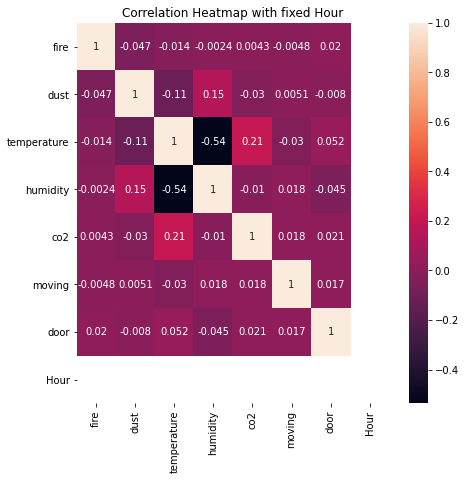

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,7))
sns.heatmap(data = datah12.corr(), annot=True ) 
plt.title("Correlation Heatmap with fixed Hour")

In [7]:
data4=data[['dust','temperature','humidity','co2']]

In [43]:
from sklearn.preprocessing import StandardScaler
import numpy as np
std=StandardScaler()
data4_std=std.fit_transform(data4)
scov=np.cov(data4_std.T)
eigen_vals, eigen_vecs=np.linalg.eig(scov)
print('Eigenvalues \n%s' %eigen_vals) 
# eigenvalues 크게 차이 안남..! = 우리가 pca해도 이 네 변수를 드라마틱하게 줄이거나, 이 모두를 포괄하는 새 변수를 찾긴 힘들 듯.

Eigenvalues 
[1.61745801 1.0191406  0.90553289 0.45786873]


In [11]:
from sklearn.decomposition import PCA
pca = PCA()

In [8]:
from sklearn.preprocessing import scale
data4 = scale(data4)

In [12]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
data4 = pca.fit_transform(data4)

In [17]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2','PC3'], index=['dust','temperature','humidity','co2'])
loadings

,PC1,PC2,PC3
dust,-0.160621,0.830356,0.528892
temperature,0.674794,0.110469,0.127402
humidity,-0.596409,0.235203,-0.469340
co2,0.403919,0.492936,-0.695530


In [15]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()


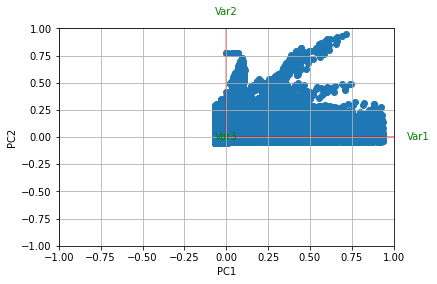

In [16]:
import numpy as np
import matplotlib.pyplot as plt
myplot(data4[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Processing dataframe..
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..


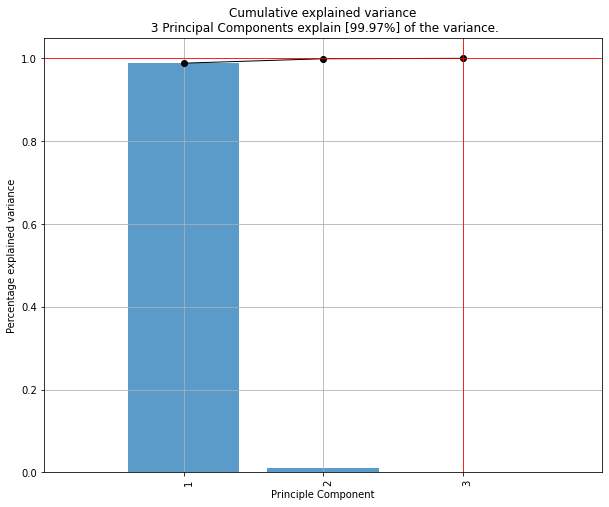

In [ ]:
from pca import pca
model = pca(n_components=3)
results = model.fit_transform(data4)
fig, ax = model.plot()
fig, ax = model.biplot(n_feat=4)

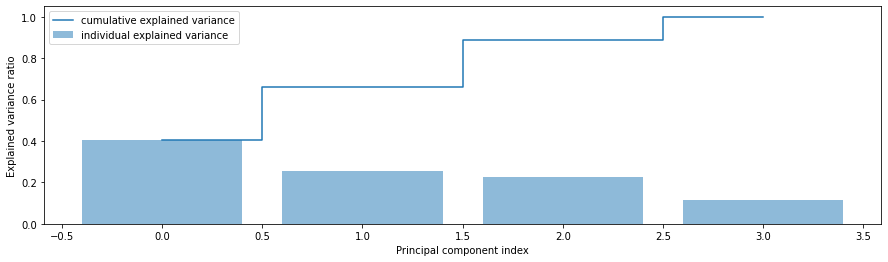

In [44]:
# 위 내용 시각화
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(0,4), var_exp, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(0,4), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
data['dust'] = std.fit_transform(data['dust'].values.reshape(-1,1))
data['temperature'] =  std.fit_transform(data['temperature'].values.reshape(-1,1))
data['humidity'] =  std.fit_transform(data['humidity'].values.reshape(-1,1))
data['co2'] =  std.fit_transform(data['co2'].values.reshape(-1,1))

In [ ]:
import numpy as np
data['roomid'].unique()

array([202, 203, 204, 205, 208, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 301, 302, 303, 304, 305, 306, 307, 308,
       309, 310, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322,
       323, 324, 325, 326, 327, 328, 329, 4001, 4002, 4003, 4004, 4006,
       4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017,
       4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028,
       4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039,
       4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050,
       4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061,
       4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072,
       4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083,
       4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094,
       4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105,
       4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 

In [ ]:
data['co2']=data['co2'].astype(float)

In [ ]:
data['roomid']=data['roomid'].astype(str)
room2=data[data.roomid.str.startswith('2')]
room3=data[data.roomid.str.startswith('3')]
room4=data[data.roomid.str.startswith('4')]
room5=data[data.roomid.str.startswith('5')]
roomB=data[data.roomid.str.startswith('B')]

Text(0.5, 1.0, 'Correlation Heatmap for floor2')

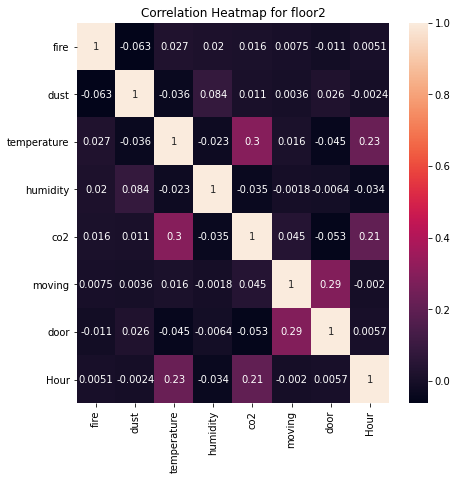

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,7))
sns.heatmap(data = data[data['floor']=='floor2'].corr(), annot=True ) 
plt.title("Correlation Heatmap for floor2")

In [12]:
df2 = data[data['floor']=='floor2']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


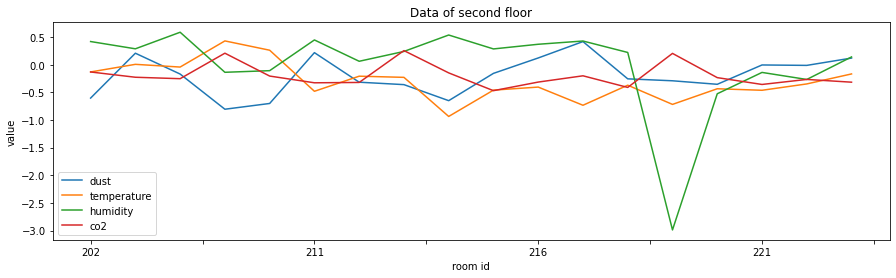

In [20]:
import matplotlib.pyplot as plt
df2 = df2.groupby(df2['roomid'])['dust','temperature','humidity','co2'].mean()
plt.rcParams["figure.figsize"] = (15,4)
df2.plot()
plt.title("Data of second floor")
plt.xlabel("room id")
plt.ylabel("value")
plt.show() # 전체 기간 동안의 plot (단위: 시간(초))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


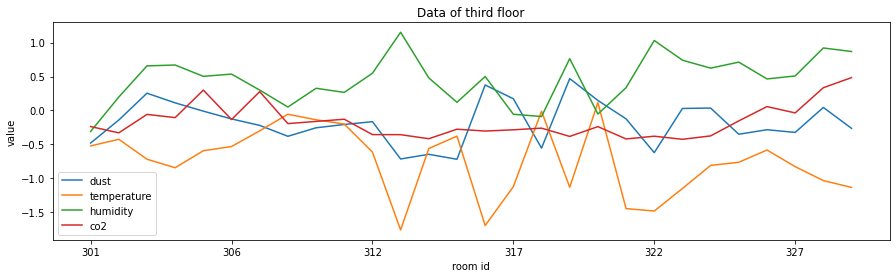

In [21]:
import matplotlib.pyplot as plt
df3 = data[data['floor']=='floor3']
df3 = data.groupby(df3['roomid'])['dust','temperature','humidity','co2'].mean()
plt.rcParams["figure.figsize"] = (15,4)
df3.plot()
plt.title("Data of third floor")
plt.xlabel("room id")
plt.ylabel("value")
plt.show() # 전체 기간 동안의 plot (단위: 시간(초))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


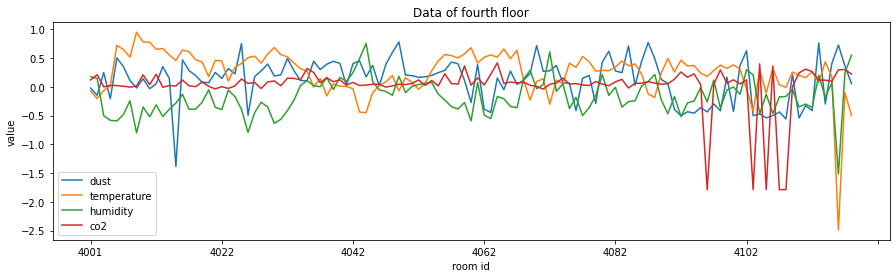

In [ ]:
import matplotlib.pyplot as plt
df4 = room4.groupby(room4['roomid'])['dust','temperature','humidity','co2'].mean()
plt.rcParams["figure.figsize"] = (15,4)
df4.plot()
plt.title("Data of fourth floor")
plt.xlabel("room id")
plt.ylabel("value")
plt.show() # 전체 기간 동안의 plot (단위: 시간(초))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


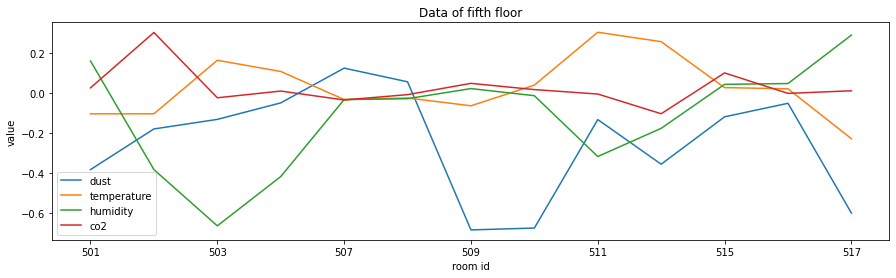

In [ ]:
import matplotlib.pyplot as plt
df5 = room5.groupby(room5['roomid'])['dust','temperature','humidity','co2'].mean()
plt.rcParams["figure.figsize"] = (15,4)
df5.plot()
plt.title("Data of fifth floor")
plt.xlabel("room id")
plt.ylabel("value")
plt.show() # 전체 기간 동안의 plot (단위: 시간(초))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


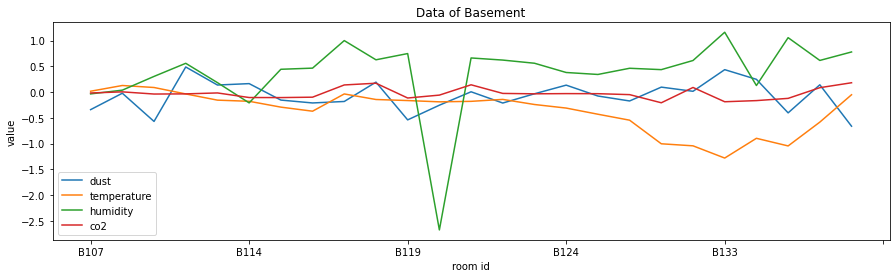

In [ ]:
import matplotlib.pyplot as plt
dfB = roomB.groupby(roomB['roomid'])['dust','temperature','humidity','co2'].mean()
plt.rcParams["figure.figsize"] = (15,4)
dfB.plot()
plt.title("Data of Basement")
plt.xlabel("room id")
plt.ylabel("value")
plt.show() # 전체 기간 동안의 plot (단위: 시간(초))

In [ ]:
print(room2.std())
print(room3.std())
print(room4.std())
print(room5.std())
print(roomB.std())

fire             0.130956
dust            18.656074
temperature      2.052858
humidity         6.591567
co2            216.716224
moving           0.068572
door             0.126850
dtype: float64
fire             0.125635
dust            18.582527
temperature      3.057826
humidity         5.960184
co2            381.343708
moving           0.081866
door             0.097331
dtype: float64
fire             0.198600
dust            20.311945
temperature      4.995102
humidity         6.410864
co2            559.849337
moving           0.093217
door             0.142613
dtype: float64
fire             0.169233
dust            17.643640
temperature      3.039928
humidity         5.458649
co2            199.501859
moving           0.080713
door             0.269868
dtype: float64
fire             0.088471
dust            22.126802
temperature      2.305135
humidity         6.977890
co2            176.547232
moving           0.081932
door             0.085534
dtype: float64


In [ ]:
data.std()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


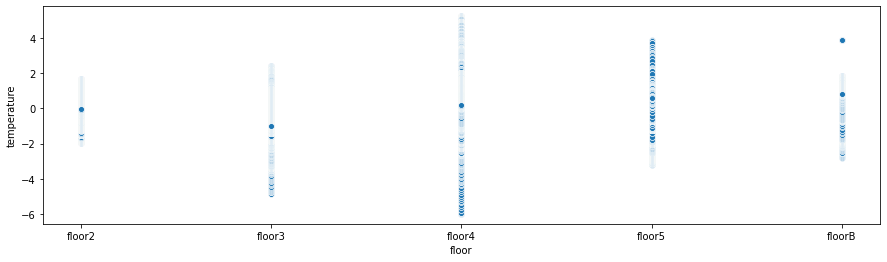

In [22]:
import seaborn as sns
sns.scatterplot(x='floor', y='temperature',  data=data)

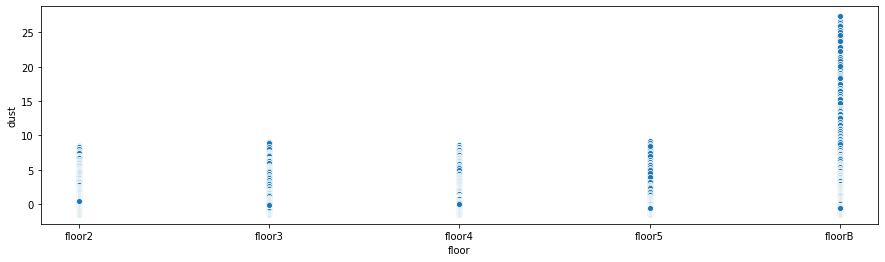

In [23]:
import seaborn as sns
sns.scatterplot(x='floor', y='dust',  data=data)

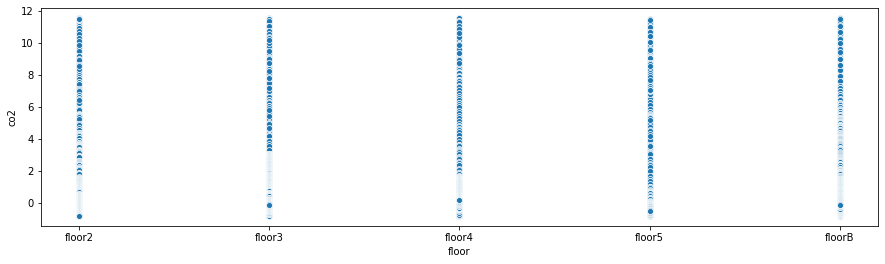

In [24]:
import seaborn as sns
sns.scatterplot(x='floor', y='co2',  data=data)

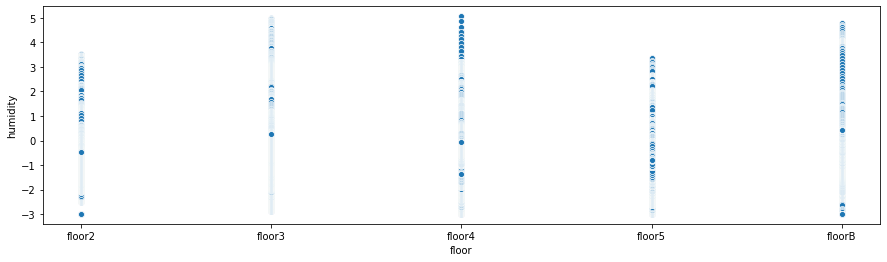

In [25]:
import seaborn as sns
sns.scatterplot(x='floor', y='humidity',  data=data)

In [ ]:
data.temperature[data['floor']=='floor4'].quantile(0) # temperature outlier 값

-99.0

In [ ]:
np.where(data.temperature<-20) # temperature oulier 갖는 값들의 index

(array([1544924, 1544925, 1544926, ..., 3537547, 3537548, 3537549]),)

In [ ]:
temperature_out = data[data.temperature>-20]
temperature_out.shape # temperature outlier 제외한 data

(17871424, 10)

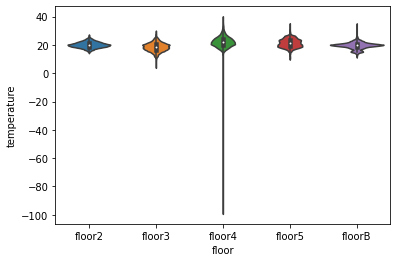

In [ ]:
import seaborn as sns
sns.violinplot(x="floor", y="temperature", data=data) # floor4 outlier 제거필요

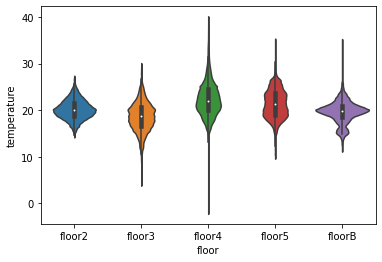

In [ ]:
import seaborn as sns
sns.violinplot(x="floor", y="temperature", data=temperature_out) # temperature outler 제거하고 그린 것 

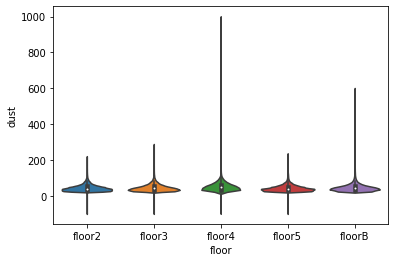

In [ ]:
import seaborn as sns
sns.violinplot(x="floor", y="dust", data=data) # floor4엔 무슨일이.. 

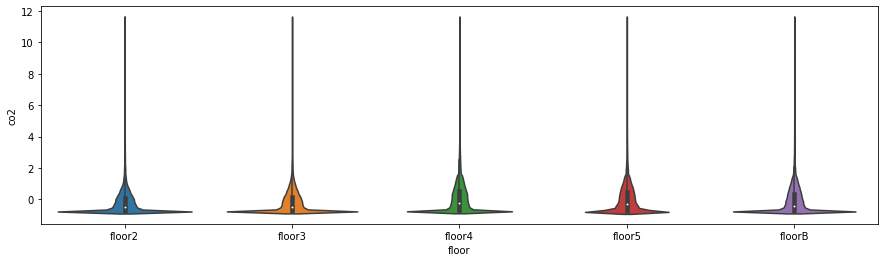

In [26]:
sns.violinplot(x="floor", y="co2", data=data) # outlier 완전많은데?

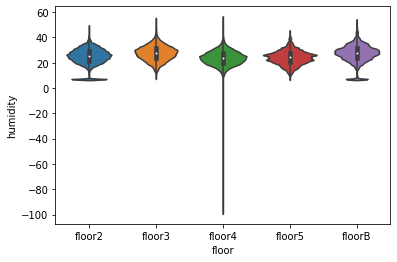

In [ ]:
sns.violinplot(x="floor", y="humidity", data=data)

In [ ]:
data.humidity[data['floor']=='floor4'].quantile(0) # humidity outlier 값

-99.0

In [ ]:
humidity_out = data[data.humidity>-20]
humidity_out.shape # humidity outlier 제외한 data

(17871424, 10)

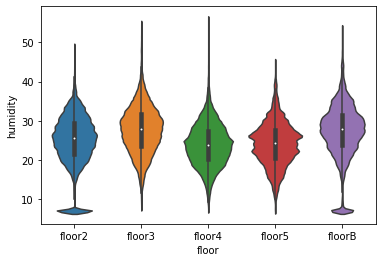

In [ ]:
import seaborn as sns
sns.violinplot(x="floor", y="humidity", data=humidity_out) # humidity outler 제거하고 그린 것 

In [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
data['dust'] = std.fit_transform(data['dust'].values.reshape(-1,1))
data['temperature'] =  std.fit_transform(data['temperature'].values.reshape(-1,1))
data['humidity'] =  std.fit_transform(data['humidity'].values.reshape(-1,1))
data['co2'] =  std.fit_transform(data['co2'].values.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


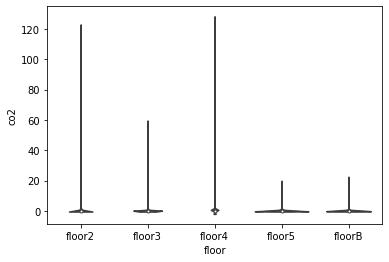

In [ ]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
data['co2'] =  std.fit_transform(data['co2'].values.reshape(-1,1))
sns.violinplot(x="floor", y="co2", data=data)

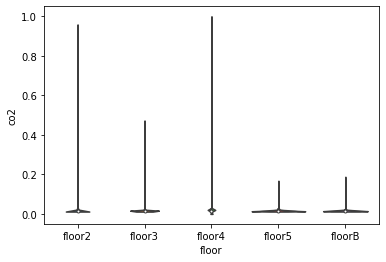

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['co2']=scaler.fit_transform(data['co2'].values.reshape(-1,1))
sns.violinplot(x="floor",y="co2",data=data)

In [ ]:
  #tukey's HSD test(층별 온도의 차이 다중비교)
  import pandas as pd
  import urllib
  import matplotlib.pyplot as plt
  import numpy as np
  %matplotlib inline
  from statsmodels.stats.multicomp import pairwise_tukeyhsd
  posthoctemp=pairwise_tukeyhsd(data['temperature'],data['floor'],alpha=0.05)
  print(posthoctemp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
floor2 floor3  -1.5529 0.001 -1.5618  -1.544   True
floor2 floor4      2.2 0.001  2.1925  2.2074   True
floor2 floor5    1.132 0.001  1.1213  1.1427   True
floor2 floorB  -0.5799 0.001 -0.5889 -0.5708   True
floor3 floor4   3.7529 0.001  3.7467  3.7591   True
floor3 floor5   2.6849 0.001   2.675  2.6948   True
floor3 floorB   0.9731 0.001   0.965  0.9811   True
floor4 floor5   -1.068 0.001 -1.0766 -1.0594   True
floor4 floorB  -2.7798 0.001 -2.7863 -2.7734   True
floor5 floorB  -1.7118 0.001 -1.7219 -1.7018   True
---------------------------------------------------


In [ ]:
  #tukey's HSD test(층별 dust의 차이 다중비교)
  import pandas as pd
  import urllib
  import matplotlib.pyplot as plt
  import numpy as np
  %matplotlib inline
  from statsmodels.stats.multicomp import pairwise_tukeyhsd
  posthocdust=pairwise_tukeyhsd(data['dust'],data['floor'],alpha=0.05)
  print(posthocdust


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
floor2 floor3   0.4709 0.001   0.416  0.5259   True
floor2 floor4   6.0134 0.001  5.9674  6.0595   True
floor2 floor5  -1.1265 0.001 -1.1926 -1.0603   True
floor2 floorB   2.2804 0.001  2.2243  2.3365   True
floor3 floor4   5.5425 0.001  5.5042  5.5808   True
floor3 floor5  -1.5974 0.001 -1.6584 -1.5364   True
floor3 floorB   1.8095 0.001  1.7595  1.8594   True
floor4 floor5  -7.1399 0.001 -7.1931 -7.0868   True
floor4 floorB   -3.733 0.001  -3.773 -3.6931   True
floor5 floorB   3.4069 0.001  3.3448  3.4689   True
---------------------------------------------------


In [ ]:
  #tukey's HSD test(층별 co2의 차이 다중비교)
  import pandas as pd
  import urllib
  import matplotlib.pyplot as plt
  import numpy as np
  %matplotlib inline
  from statsmodels.stats.multicomp import pairwise_tukeyhsd
  posthocco2=pairwise_tukeyhsd(data['co2'],data['floor'],alpha=0.05)
  print(posthocco2)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
floor2 floor3   8.0409 0.001   7.3274   8.7544   True
floor2 floor4  22.9756 0.001  22.3776  23.5735   True
floor2 floor5  43.6745 0.001  42.8152  44.5339   True
floor2 floorB  20.2539 0.001  19.5253  20.9826   True
floor3 floor4  14.9346 0.001  14.4376  15.4317   True
floor3 floor5  35.6336 0.001  34.8411  36.4262   True
floor3 floorB   12.213 0.001  11.5645  12.8614   True
floor4 floor5   20.699 0.001  20.0086  21.3893   True
floor4 floorB  -2.7217 0.001  -3.2403   -2.203   True
floor5 floorB -23.4206 0.001 -24.2269 -22.6144   True
-----------------------------------------------------


In [ ]:
  #tukey's HSD test
  import pandas as pd
  import urllib
  import matplotlib.pyplot as plt
  import numpy as np
  %matplotlib inline
  from statsmodels.stats.multicomp import pairwise_tukeyhsd
  posthochumid=pairwise_tukeyhsd(data['humidity'],data['floor'],alpha=0.05)
  print(posthochumid)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
floor2 floor3   2.7893 0.001  2.7733  2.8053   True
floor2 floor4  -1.0552 0.001 -1.0686 -1.0418   True
floor2 floor5   -0.769 0.001 -0.7883 -0.7497   True
floor2 floorB   2.4034 0.001  2.3871  2.4198   True
floor3 floor4  -3.8445 0.001 -3.8557 -3.8334   True
floor3 floor5  -3.5583 0.001 -3.5761 -3.5405   True
floor3 floorB  -0.3858 0.001 -0.4004 -0.3713   True
floor4 floor5   0.2862 0.001  0.2708  0.3017   True
floor4 floorB   3.4587 0.001   3.447  3.4703   True
floor5 floorB   3.1724 0.001  3.1544  3.1905   True
---------------------------------------------------
